### **Phần 1: Giải thuật K-Means**

**1. Import thư viện và tập dữ liệu**

In [57]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df = pd.read_csv("penguins.csv")
df.info()
df.head().style.background_gradient(cmap=sns.cubehelix_palette(as_cmap=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.100000,18.700000,181.000000,3750.000000,MALE
1,39.500000,17.400000,186.000000,3800.000000,FEMALE
2,40.300000,18.000000,195.000000,3250.000000,FEMALE
3,nan,nan,nan,nan,nan
4,36.700000,19.300000,193.000000,3450.000000,FEMALE


**2. Tiền xử lý dữ liệu**

In [58]:
# Chuyển đổi giới tính: Male=1, Female=0
df['sex'] = df['sex'].map({'MALE': 1, "FEMALE": 0})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                334 non-null    float64
dtypes: float64(5)
memory usage: 13.6 KB


In [59]:
print("Số lượng giá trị bị thiếu trên mỗi cột:")
print(df.isnull().sum())

Số lượng giá trị bị thiếu trên mỗi cột:
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64


In [60]:
# Các hàng bị thiếu tất cả các giá trị bị thiếu sẽ bị loại bỏ
df = df.dropna(how='all')
print(df.isnull().sum())

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  8
dtype: int64


In [61]:
# Dùng Naive Bayes để ước lượng các giá trị bị thiếu
from sklearn.naive_bayes import GaussianNB

# Tạo DataFrame với các hàng không có giá trị thiếu để huấn luyện
df_no_missing = df.dropna()

# Huấn luyện mô hình với dữ liệu đầy đủ
X_train = df_no_missing.drop("sex", axis=1)
y_train = df_no_missing["sex"]

model = GaussianNB()
model.fit(X_train, y_train)

# Dự đoán giá trị sex cho các hàng bị thiếu
df_missing = df[df.isnull().any(axis=1)]
if len(df_missing) > 0:
    X_missing = df_missing.drop("sex", axis=1).fillna(df_missing.mean())
    predictions = model.predict(X_missing)
    df.loc[df.isnull().any(axis=1), "sex"] = predictions

print("Số lượng giá trị bị thiếu sau khi điền:")
print(df.isnull().sum())

Số lượng giá trị bị thiếu sau khi điền:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


In [62]:
print("\nSố lượng hàng bị trùng lặp:")
print(df.duplicated().sum())


Số lượng hàng bị trùng lặp:
0


In [63]:
# Xem các dòng có ít nhất một giá trị âm trong các cột số
negative_rows = df[
    (df['culmen_length_mm'] < 0) | 
    (df['culmen_depth_mm'] < 0) | 
    (df['flipper_length_mm'] < 0) | 
    (df['body_mass_g'] < 0)
]

print("Các hàng chứa dữ liệu âm:")
display(negative_rows)

Các hàng chứa dữ liệu âm:


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
14,34.6,21.1,-132.0,4400.0,1.0


In [64]:
drop_indices = negative_rows.index
df = df.drop(drop_indices).reset_index(drop=True)

**3. EDA**

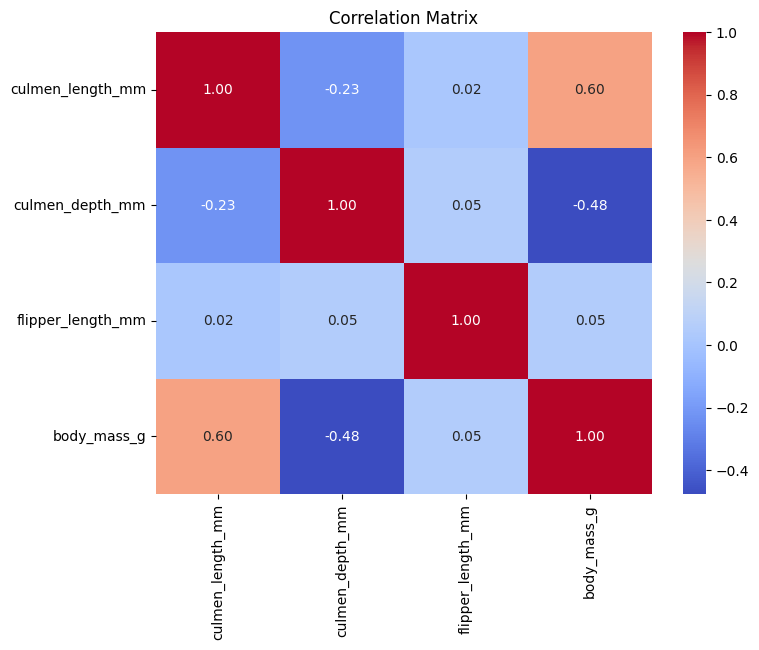

In [65]:
# Heatmap: Xem tương quan giữa các biến
plt.figure(figsize=(8, 6))
sns.heatmap(df[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Pairplot: Phân bố các cụm
fig = px.scatter_matrix(
    df,
    dimensions=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'],
    color="sex",
    title="Scatter Matrix (Tổng quan dữ liệu)",
    color_discrete_sequence=['#491D8B', '#EB548C']
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [66]:
my_colors = ['#491D8B', '#EB548C']

# 1. Biểu đồ tròn
fig = px.pie(df, 'sex', 
             color_discrete_sequence=my_colors,
             title='Data Distribution (Sex)', 
             template='plotly')
fig.show()

# 2. Box-plot: Chiều dài mỏ
fig = px.box(data_frame=df, x='sex', y='culmen_length_mm',
             color='sex',
             color_discrete_sequence=my_colors,
             orientation='v',
             title='Box-plot: Culmen Length by Sex')
fig.show()

# 3. Histogram: Chiều dài mỏ
fig = px.histogram(data_frame=df, x='culmen_length_mm',
                   color='sex',
                   color_discrete_sequence=my_colors,
                   nbins=50,
                   title='Histogram: Culmen Length Distribution')
fig.show()

# 4. Box-plot: Độ sâu mỏ
fig = px.box(data_frame=df, x='sex', y='culmen_depth_mm', 
             color='sex',
             color_discrete_sequence=my_colors,
             orientation='v',
             title='Box-plot: Culmen Depth by Sex')
fig.show()

# 5. Scatter Plot: Chiều dài mỏ vs Độ sâu mỏ
fig = px.scatter(data_frame=df, x='culmen_length_mm', y='culmen_depth_mm',
                 color='sex', size='flipper_length_mm',
                 template='seaborn',
                 color_discrete_sequence=my_colors,
                 title='Scatter: Culmen Length vs Depth')
fig.update_layout(width=800, height=600,
                  xaxis=dict(color="#BF40BF"), yaxis=dict(color="#BF40BF"))
fig.show()

# 6. Scatter Plot: Cánh vs Cân nặng (Sẽ thấy rõ tương quan sau khi sửa)
fig = px.scatter(data_frame=df, x='flipper_length_mm', y='body_mass_g',
                 color='sex', size='culmen_length_mm',
                 template='seaborn',
                 color_discrete_sequence=my_colors,
                 title='Scatter: Flipper Length vs Body Mass')
fig.update_layout(width=800, height=600,
                  xaxis=dict(color="#BF40BF"), yaxis=dict(color="#BF40BF"))
fig.show()


**4. Tìm số cụm tối ưu và huấn luyện mô hình**

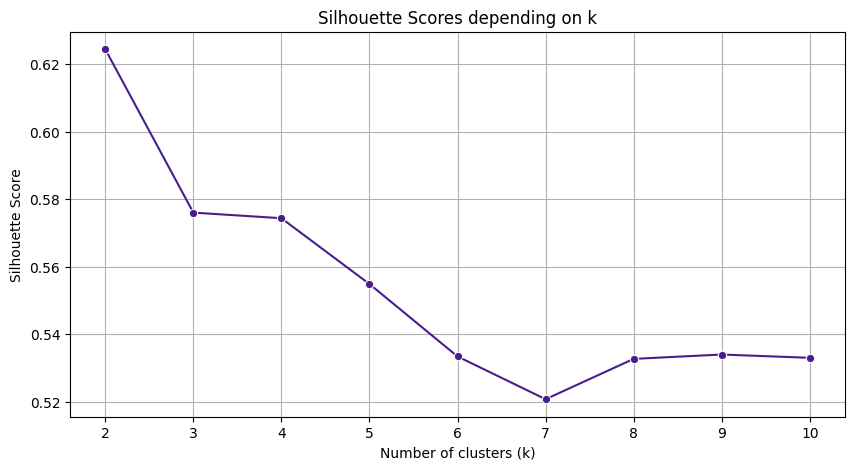

Số cụm tối ưu theo Silhouette là: k=2 với score=0.6244


In [67]:
X = df.drop('sex', axis=1)
from sklearn.metrics import silhouette_score

#  Tính toán Silhouette Score 
km_scores = []
k_range = range(2, 11)  

for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df) 
    
    # Tính score và lưu lại
    score = silhouette_score(df, kmeans.labels_)
    km_scores.append(score)

# Vẽ biểu đồ Silhouette (Code của bạn) 
plt.figure(figsize=(10, 5))
sns.lineplot(x=k_range, y=km_scores, marker='o', color='#491D8B') # Thêm marker='o' cho dễ nhìn
plt.title('Silhouette Scores depending on k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# In ra k tối ưu theo Silhouette
best_k = k_range[np.argmax(km_scores)]
print(f"Số cụm tối ưu theo Silhouette là: k={best_k} với score={max(km_scores):.4f}")

# Phương pháp Elbow 
sse = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=42, n_init=10)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

fig = px.line(x=range(1, 11), y=sse, template="seaborn", title='Elbow Method')
fig.update_layout(width=800, height=600, 
                  title_font_color="#BF40BF",
                  xaxis=dict(color="#BF40BF", title="Clusters"),
                  yaxis=dict(color="#BF40BF", title="SSE"))
fig.show()

#  Chạy mô hình cuối cùng 
# Bạn có thể chọn k=4 hoặc k theo best_k tìm được ở trên
kmeans_final = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_final.fit_predict(df)

In [ ]:

# Chạy K-means với k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Vẽ kết quả clustering 
fig = go.Figure()

colors = ['#FF6B6B', '#4ECDC4']  # Màu cho 2 cụm

for i in range(2):
    fig.add_trace(go.Scatter(
        x=X[clusters == i].iloc[:, 0],  
        y=X[clusters == i].iloc[:, 1],  
        mode='markers',
        marker=dict(color=colors[i], size=10, opacity=0.8),
        name=f'Cụm {i}'
    ))

# Vẽ tâm cụm
fig.add_trace(go.Scatter(
    x=kmeans.cluster_centers_[:, 0],
    y=kmeans.cluster_centers_[:, 1],
    mode='markers+text',
    marker=dict(color='white', size=14, symbol='x', line=dict(width=3, color='yellow')),
    text=[f'Center {i}' for i in range(2)],
    textposition='bottom center',
    name='Tâm cụm'
))

fig.update_layout(
    template='plotly_dark',
    width=1000,
    height=600,
    title='<b>K-Means Clustering Results (k=2)</b>',
    #xaxis_title='Chiều dài mỏ (culmen_length_mm)',
    #yaxis_title='Độ sâu mỏ (culmen_depth_mm)',
    legend_title='Nhóm'
)
fig.show()

# Phân tích tỷ lệ giới tính trong từng cụm (liên kết với dự đoán giới tính)
df['cluster'] = clusters
print(df.groupby('cluster')['sex'].value_counts(normalize=True).unstack().fillna(0))



sex           0.0       1.0
cluster                    
0        0.574163  0.425837
1        0.401515  0.598485


### **Phần 2: Phân cụm đa cấp**

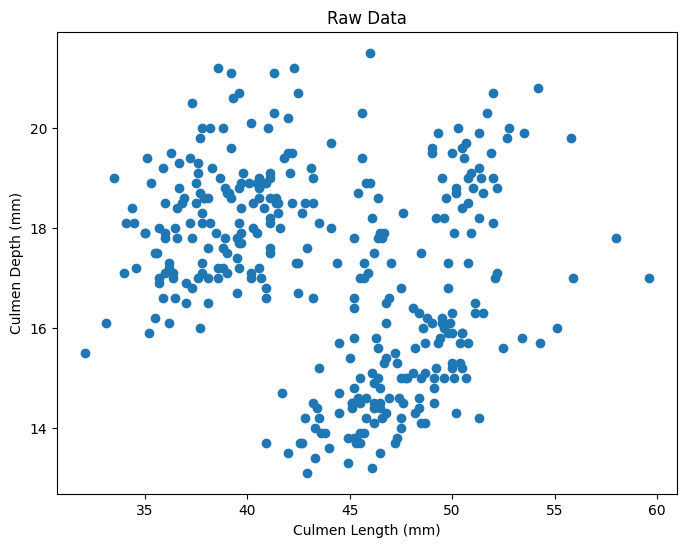

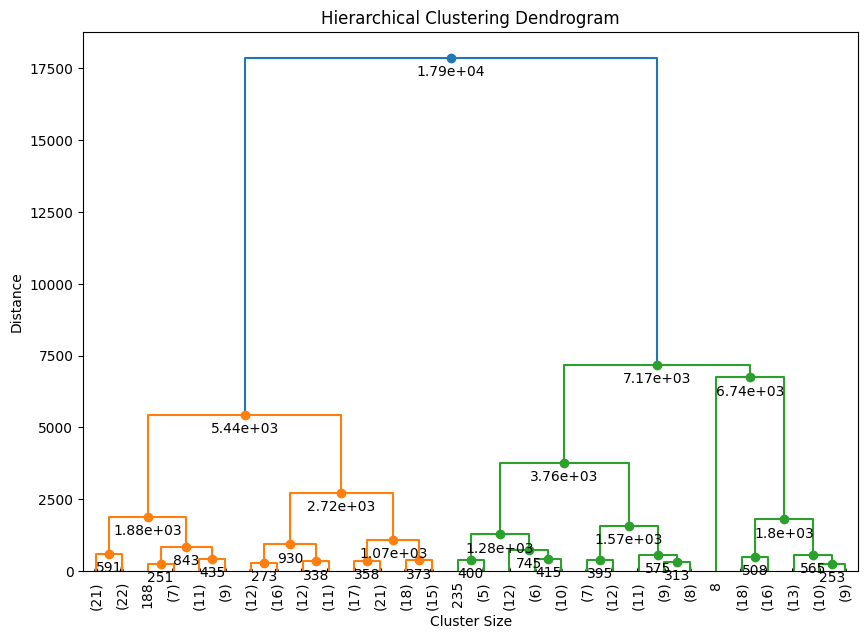

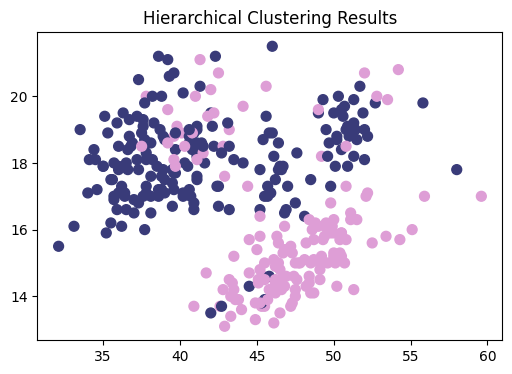

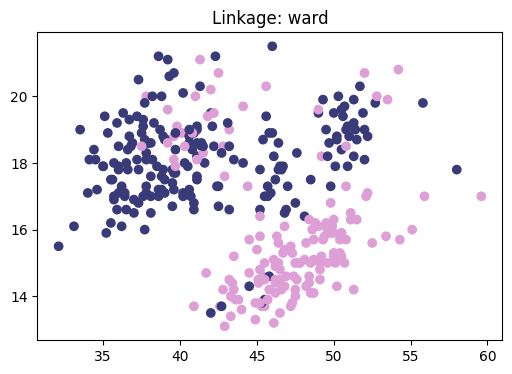

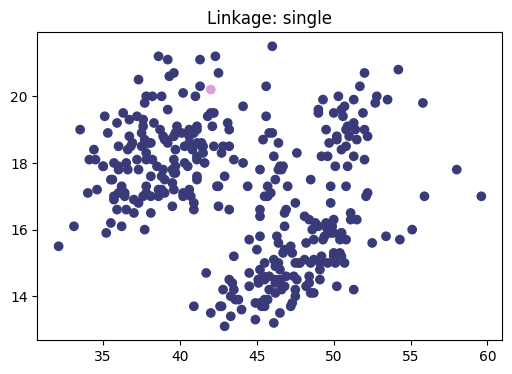

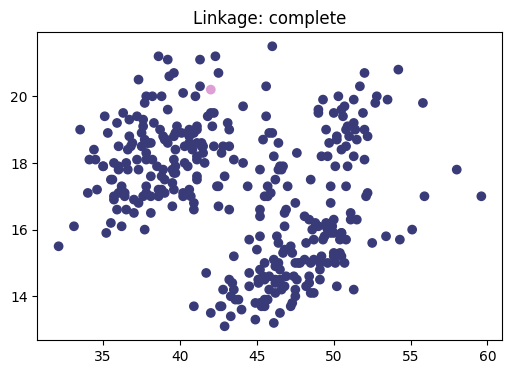

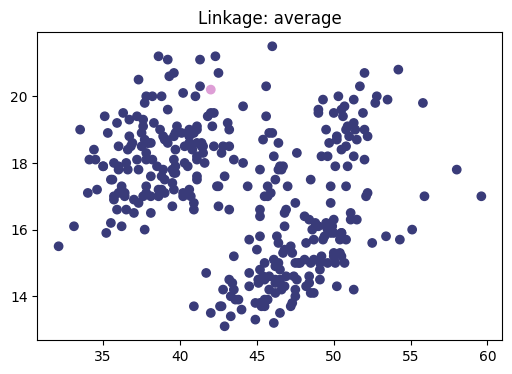

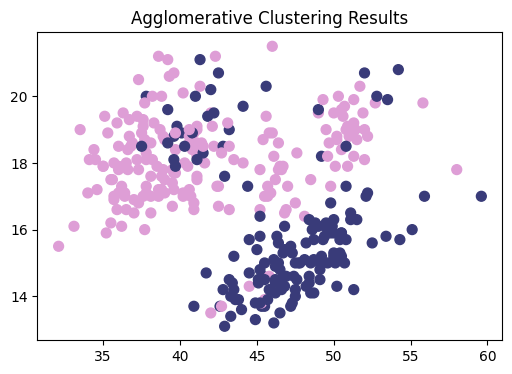

In [70]:
# --- 1. Import và chuẩn bị dữ liệu ---
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering


# Chuẩn bị dữ liệu
X = df[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].dropna()
X_array = X.values

# Hiển thị dữ liệu thô
plt.figure(figsize=(8, 6))
plt.scatter(X_array[:, 0], X_array[:, 1])
plt.title('Raw Data')
plt.xlabel('Culmen Length (mm)')
plt.ylabel('Culmen Depth (mm)')
plt.show()

# --- 2. Tính toán ma trận khoảng cách ---
distances = linkage(X_array, method="ward", metric="euclidean")

# --- 3. Vẽ Dendrogram ---
def annotated_dendrogram(*args, **kwargs):
    scipy_dendro = dendrogram(*args, truncate_mode='lastp',
                              show_contracted=True, leaf_rotation=90.)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Cluster Size')  # Sửa lỗi ở đây
    plt.ylabel('Distance')

    for i, d, c in zip(scipy_dendro['icoord'], scipy_dendro['dcoord'], scipy_dendro['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        if y > 10:
            plt.plot(x, y, 'o', c=c)
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                         textcoords='offset points', va='top', ha='center')
    return scipy_dendro

plt.figure(figsize=(10, 7))
dn = annotated_dendrogram(distances)
plt.show()

# --- 4. Vẽ các cụm từ kết quả SciPy ---
scipy_clusters = fcluster(distances, 2, criterion="maxclust")

plt.figure(figsize=(6, 4))
plt.title("Hierarchical Clustering Results")
plt.scatter(X_array[:, 0], X_array[:, 1], c=scipy_clusters, s=50, cmap='tab20b')
plt.show()

# --- 5. Thử nghiệm các phương pháp linkage khác nhau ---
methods = ['ward', 'single', 'complete', 'average']
for method in methods:
    distances_method = linkage(X_array, method=method, metric="euclidean")
    clusters_method = fcluster(distances_method, 2, criterion="maxclust")
    plt.figure(figsize=(6, 4))
    plt.title(f'Linkage: {method}')
    plt.scatter(X_array[:, 0], X_array[:, 1], c=clusters_method, cmap='tab20b')
    plt.show()

# --- 6. Phân cụm Đa cấp với Scikit-learn ---
ac = AgglomerativeClustering(n_clusters=2, linkage="ward")
sklearn_clusters = ac.fit_predict(X_array)

plt.figure(figsize=(6, 4))
plt.title("Agglomerative Clustering Results")
plt.scatter(X_array[:, 0], X_array[:, 1], c=sklearn_clusters, s=50, cmap='tab20b')
plt.show()

### **Phần 3: So sánh K-Means và Phân cụm Đa cấp**

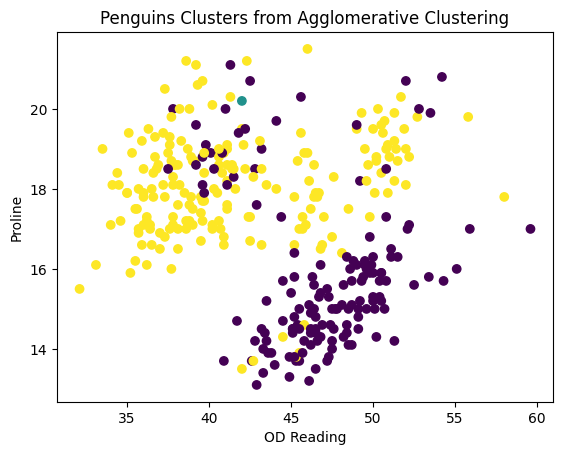

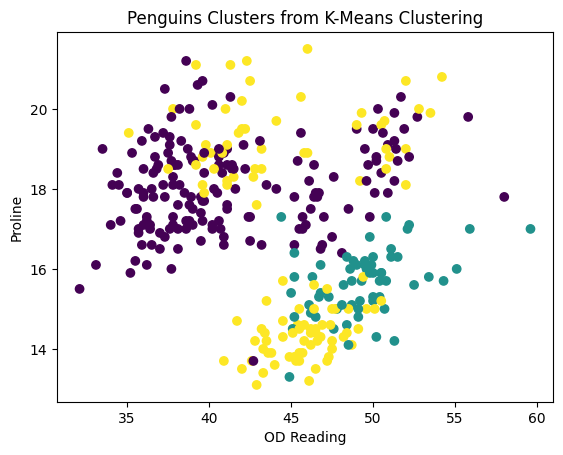

Silhouette Scores for Penguins Dataset:

K-Means Clustering:  0.5760511254756772
Agg Clustering:  0.6233988789196517


In [71]:
# --- 1. Import và load dữ liệu Penguins ---
from sklearn.metrics import silhouette_score


# --- 2. Phân cụm Đa cấp (Agglomerative) ---
ac = AgglomerativeClustering(n_clusters=3, linkage='average')
ac_clusters = ac.fit_predict(df)

# Hiển thị kết quả Agglomerative
plt.scatter(df.values[:,0], df.values[:,1], c=ac_clusters)
plt.title("Penguins Clusters from Agglomerative Clustering")
plt.xlabel("OD Reading")
plt.ylabel("Proline")
plt.show()

# --- 3. Phân cụm K-Means ---
km = KMeans(n_clusters=3)
km_clusters = km.fit_predict(df)

# Hiển thị kết quả K-Means
plt.scatter(df.values[:,0], df.values[:,1], c=km_clusters)
plt.title("Penguins Clusters from K-Means Clustering")
plt.xlabel("OD Reading")
plt.ylabel("Proline")
plt.show()

# --- 4. So sánh bằng chỉ số Silhouette ---
print("Silhouette Scores for Penguins Dataset:\n")
print("K-Means Clustering: ", silhouette_score(df, km_clusters))
print("Agg Clustering: ", silhouette_score(df, ac_clusters))